In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ndcg_score
import random
from scipy.stats import kendalltau
from multielo import MultiElo
import statistics

In [20]:
elo = MultiElo() 

In [21]:
df = pd.read_csv('contest_results_multi_elo.csv', parse_dates=['contest_date'])

In [22]:
df = df.sort_values(
    by=[
        "contest_date",
        "organization",
        "contest_name",
        "division",
        "class",
        "placing"
    ],
    ascending=True,
)

In [23]:
df.head()

,Unnamed: 0,organization,contest_name,contest_date,division,class,competitor_name,placing,professional_only,multielo_rating,multielo_rank
0,17038,ifbb,ifbb flex pro,2012-02-18,fitness,open,adela garcia,1.0,True,1529.333333,1.0
1,17037,ifbb,ifbb flex pro,2012-02-18,fitness,open,oksana grishina,2.0,True,1524.000000,2.0
2,17036,ifbb,ifbb flex pro,2012-02-18,fitness,open,myriam capes,3.0,True,1518.666667,3.0
3,17035,ifbb,ifbb flex pro,2012-02-18,fitness,open,tanji johnson,4.0,True,1513.333333,4.0
4,17034,ifbb,ifbb flex pro,2012-02-18,fitness,open,bethany wagner,5.0,True,1508.000000,5.0


# Evaluating Ranking Metrics

In [24]:
rows_list = []
for org in df['organization'].unique():
    df_org = df[df['organization'] == org]
    for div in df_org["division"].unique():
        df_div = df_org[df_org['division'] == div]
        print(div)
        for clss in df_div["class"].unique():
            df_clss = df_div[df_div['class'] == clss]
            for dt in df["contest_date"].unique():
                df_dt = df_clss[df_clss["contest_date"] == dt]
                ndcg_scores = []
                ndcg_scores_random = []
                kt_corr = []
                kt_pvalues = []
                kt_corr_random = []
                kt_pvalues_random = []
                prec_5_scores = []
                prec_5_scores_random = []
                multielo_prob = []
                multielo_prob_random = []
                for ctst in df_dt["contest_name"].unique():
                    temp_df = df_dt[df_dt["contest_name"] == ctst]
                    temp_df = temp_df.dropna()
                    if len(temp_df) < 2:
                        continue
                    y_true = temp_df["placing"]
                    y_predict = temp_df["multielo_rank"]
                    y_multielo_rating = list(temp_df["multielo_rating"])
                    multielo_prob.append(statistics.mean(list(np.diag(elo.simulate_win_probabilities(y_multielo_rating)))))
                    random.shuffle(y_multielo_rating)
                    multielo_prob_random.append(statistics.mean(list(np.diag(elo.simulate_win_probabilities(y_multielo_rating)))))
                    ndcg_scores.append(ndcg_score([y_true], [y_predict], ignore_ties=True))
                    kt_corr.append(kendalltau(y_true, y_predict).statistic)
                    kt_pvalues.append(kendalltau(y_true, y_predict).pvalue)
                    y_predict = list(y_predict)
                    random.shuffle(y_predict)
                    ndcg_scores_random.append(
                        ndcg_score([y_true], [y_predict], ignore_ties=True)
                    )
                    kt_corr_random.append(kendalltau(y_true, y_predict).statistic)
                    kt_pvalues_random.append(kendalltau(y_true, y_predict).pvalue)
                    if len(temp_df) > 5:
                        top_5_placing = temp_df.sort_values(by=['placing'], ascending=True).head(5)
                        top_5_elo = temp_df.sort_values(by=['multielo_rank'], ascending=True).head(5)
                        prec_5_scores.append(0.2 * len(pd.merge(top_5_placing, top_5_elo, how='inner', on=['competitor_name'])))
                        top_5_random = temp_df.sample(5)
                        prec_5_scores_random.append(0.2 * len(pd.merge(top_5_placing, top_5_random, how='inner', on=['competitor_name'])))
                if ndcg_scores:
                    if not prec_5_scores:
                        prec_5_score = None
                        prec_5_score_random = None
                    else:
                        prec_5_score = sum(prec_5_scores) / len(prec_5_scores)
                        prec_5_score_random = sum(prec_5_scores_random) / len(prec_5_scores_random)
                    rows_list.append(
                        {
                            "date": dt,
                            "organization": org,
                            "division": div,
                            "class": clss,
                            "ndcg_score": sum(ndcg_scores) / len(ndcg_scores),
                            "ndcg_score_random": sum(ndcg_scores_random)
                            / len(ndcg_scores_random),
                            "kt_corr": sum(kt_corr) / len(kt_corr),
                            "kt_corr_random": sum(kt_corr_random)
                            / len(kt_corr_random),
                            "kt_pvalue": sum(kt_pvalues) / len(kt_pvalues),
                            "kt_pvalue_random": sum(kt_pvalues_random)
                            / len(kt_pvalues_random),
                            "prec_5_score": prec_5_score,
                            "prec_5_score_random": prec_5_score_random,
                             "multielo_prob": sum(multielo_prob)/len(multielo_prob),
                            "multielo_prob_random": sum(multielo_prob_random)/len(multielo_prob_random)
                        }
                    )

fitness
men's bodybuilding
bikini
figure
women's bodybuilding
women's physique
men's physique
212
men's classic physique
wellness
bikini
figure
fitness
men's bodybuilding
men's physique
women's bodybuilding
women's physique
men's classic physique
wellness
bikini
figure
fitness
men's bodybuilding
men's classic physique
men's physique
women's physique
wellness
women's bodybuilding
bikini
figure
men's bodybuilding
men's classic physique
men's physique
women's physique
fitness
women's bodybuilding
wellness


In [25]:
metric_df = pd.DataFrame(rows_list)
for met in [ 'ndcg_score', 'ndcg_score_random', 'kt_corr', 'kt_corr_random',
            'kt_pvalue', 'kt_pvalue_random', 'prec_5_score', 'prec_5_score_random',"multielo_prob","multielo_prob_random"]:
    metric_df[f'30dayrollavg_{met}'] = metric_df.groupby(['organization', 'division', 'class'])[met].transform(lambda x: x.rolling(30, 1).mean())

In [26]:
metric_df.to_csv('metric_data_multielo.csv')

In [27]:
metric_df.head()

,date,organization,division,class,ndcg_score,ndcg_score_random,kt_corr,kt_corr_random,kt_pvalue,kt_pvalue_random,...,30dayrollavg_ndcg_score,30dayrollavg_ndcg_score_random,30dayrollavg_kt_corr,30dayrollavg_kt_corr_random,30dayrollavg_kt_pvalue,30dayrollavg_kt_pvalue_random,30dayrollavg_prec_5_score,30dayrollavg_prec_5_score_random,30dayrollavg_multielo_prob,30dayrollavg_multielo_prob_random
0,2012-02-18,ifbb,fitness,open,1.000000,0.707637,1.000000,-0.393939,4.175351e-09,0.086317,...,1.000000,0.707637,1.000000,-0.393939,4.175351e-09,0.086317,1.000000,0.40,0.092087,0.084667
1,2012-03-02,ifbb,fitness,open,0.997229,0.935064,0.846154,0.362637,1.514437e-06,0.079457,...,0.998615,0.821351,0.923077,-0.015651,7.593060e-07,0.082887,0.900000,0.30,0.086683,0.078422
2,2012-03-16,ifbb,fitness,open,0.946898,0.755731,0.722222,0.000000,5.886243e-03,1.000000,...,0.981376,0.799477,0.856125,-0.010434,1.962587e-03,0.388591,0.866667,0.40,0.099806,0.092692
3,2012-05-05,ifbb,fitness,open,0.983478,0.785981,0.722222,0.000000,5.886243e-03,1.000000,...,0.981901,0.796103,0.822650,-0.007826,2.943501e-03,0.541444,0.850000,0.40,0.106411,0.097956
4,2012-06-01,ifbb,fitness,open,0.968876,0.853797,0.600000,-0.018182,9.945537e-03,1.000000,...,0.979296,0.807642,0.778120,-0.009897,4.343908e-03,0.633155,0.880000,0.36,0.105408,0.096792


In [28]:
metric_df = pd.read_csv('metric_data_multielo.csv', parse_dates=["date"])

Text(0, 0.5, '30-day Rolling Average Precision 5 score')

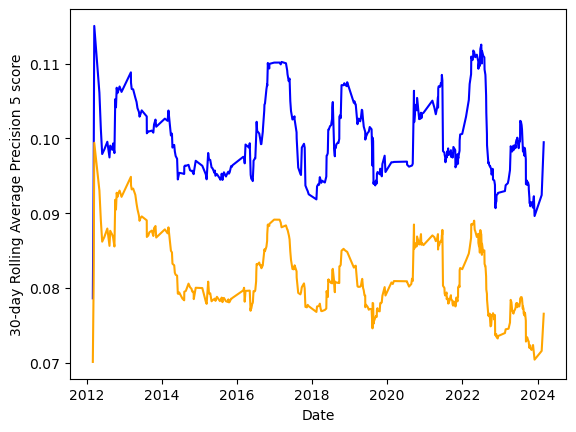

In [29]:
ax = sns.lineplot(
    data=metric_df[
        (metric_df["organization"] == "ifbb")
        & (metric_df["division"] == "bikini")
        & (metric_df["class"] == "open")
    ],
    x="date",
    y="30dayrollavg_multielo_prob",
    color="blue"
)
ax2 = sns.lineplot(
    data=metric_df[
        (metric_df["organization"] == "ifbb")
        & (metric_df["division"] == "bikini")
        & (metric_df["class"] == "open")
    ],
    x="date",
    y="30dayrollavg_multielo_prob_random",
    color="orange"
)
plt.xlabel("Date")
plt.ylabel("30-day Rolling Average Precision 5 score")
# plt.axhline(0.05, color='green')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

Text(0, 0.5, '30-day Rolling Average Precision 5 score')

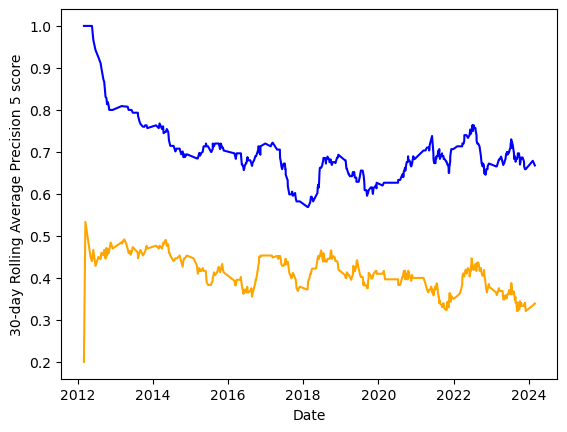

In [30]:
ax = sns.lineplot(
    data=metric_df[
        (metric_df["organization"] == "ifbb")
        & (metric_df["division"] == "bikini")
        & (metric_df["class"] == "open")
    ],
    x="date",
    y="30dayrollavg_prec_5_score",
    color="blue"
)
ax2 = sns.lineplot(
    data=metric_df[
        (metric_df["organization"] == "ifbb")
        & (metric_df["division"] == "bikini")
        & (metric_df["class"] == "open")
    ],
    x="date",
    y="30dayrollavg_prec_5_score_random",
    color="orange"
)
plt.xlabel("Date")
plt.ylabel("30-day Rolling Average Precision 5 score")
# plt.axhline(0.05, color='green')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [31]:
df_winners = df[df['placing'] == 1]
df_gb = df_winners.groupby(["organization",
                            "division",
                            "class",
                            "contest_date"])["multielo_rating"].mean()
df_elo_winners = pd.DataFrame(df_gb).reset_index()
df_elo_winners = df_elo_winners.sort_values(by = ["contest_date", "organization", "division", "class"])
df_elo_winners["30dayrollavg_win_multielo_rating"] = df_elo_winners.groupby(["organization", 'division', 'class'])["multielo_rating"].transform(lambda x: x.rolling(30, 30).mean())

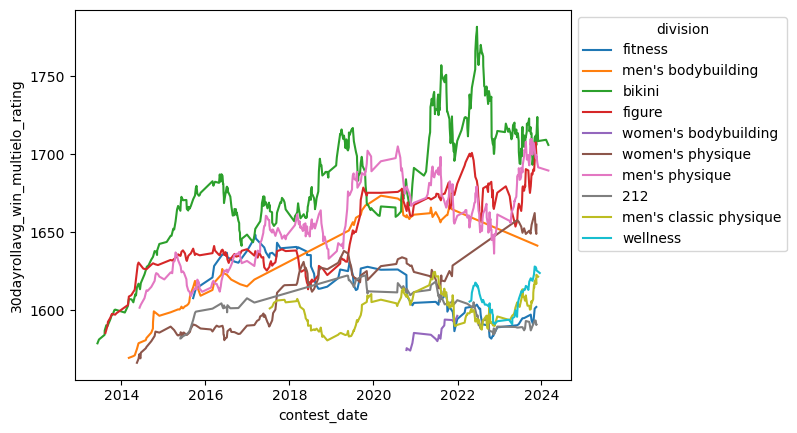

In [32]:
ax = sns.lineplot(
    data=df_elo_winners[
        (df_elo_winners["organization"] == "ifbb")
        & (df_elo_winners["class"] == "open")
    ],
    x="contest_date",
    y="30dayrollavg_win_multielo_rating",
    hue="division"
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))